## Histogram of Oriented Gradients
### Florian Heringa
### 10385835
### UvA -- Computer Vision and Image Processing

In [32]:
# Import statements

import numpy as np
import matplotlib.pyplot as plt

from skimage import color
from scipy.ndimage import imread
from skimage.transform import resize
from pylab import rcParams
from numpy.linalg import norm
from skimage.filters import sobel_h, sobel_v

#ipython setting
rcParams['figure.figsize'] = (20, 12)

$\newcommand{\vecl}[1]{\begin{pmatrix}#1\end{pmatrix}}$ 
$\newcommand{\hvec}[1]{\widetilde{\boldsymbol{#1}}}$
$\newcommand{\nvec}[1]{\boldsymbol{#1}}$

## Histogram of oriented gradients

In this report the higtogram of oriented gradients (HOG) feature vector of an image is being calculated and then being used to visualise the gradient directions in 8x8 blocks in the image. This feature vector by itself is not very useful, but by using it in algorithms like SIFT or feeding it into a neural network a large scala of image clasification schemes can be easily used.

The main idea of the HOG is to calculate the gradient of each point in the image and then converting this value to a magnitue and a direction. This way it is easy to visualise in which direction, or angle, the greatest change in value is in the image. Since value is ill defined in color images (you would for example need to know the brightness or define something yourself depending on the situation) we choose to use grayscale, or "scalar" images in this report. Also, we are only interested in non-color features like, for example, the location of a face or the existence of a human silhouette in the picture.

First, from a larger image, a single figure is being extracted so we can get the HOG descriptor for a silhouette of a running person.

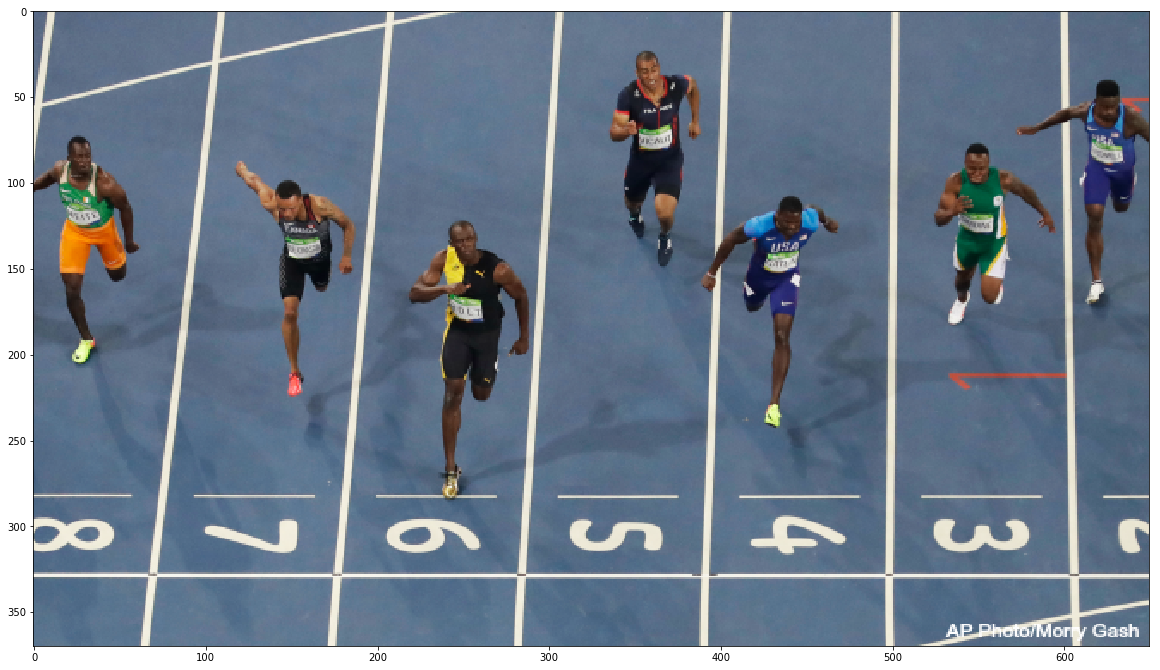

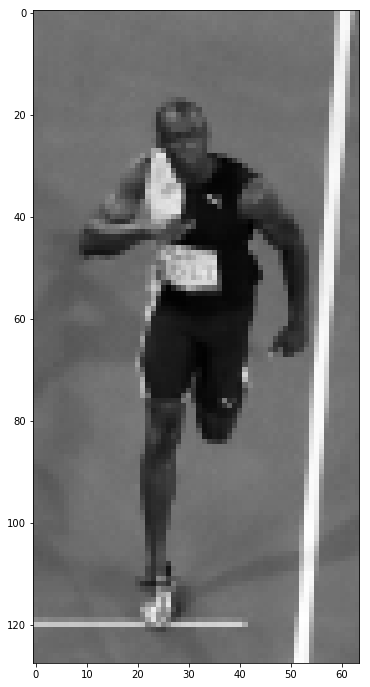

In [28]:
# Gets a subselection of a larger image
def subImage(f, yRange, xRange, yAnchor, xAnchor):
    
    return f[xAnchor:xAnchor+xRange:, yAnchor:yAnchor+yRange:]

# Load full image
bolt_full = imread('bolt2.png')

# Show full image
plt.imshow(bolt_full)
plt.show()

# Take subselection of imag of single person, convert to graysclae and 128x64 resolution
bolt = resize(color.rgb2gray(subImage(bolt_full, 100, 200, 205, 95)), (128, 64))

# Show converted image
plt.imshow(bolt, cmap='gray')
plt.show()

The reason for selecting only a 64x128 resolution image is mostly that it is both easy to work with, and that it is contains enough information to be able to extract a usefull HOG desciptor. Also, the original article used this method to identify pedestrians, which explains the aspect ratio.

Before we can get into calulating the HOG descriptor we need some helper functions. First we need a function which can change gradient images in cartesian coordinates into images in polar coordinates. This is done by making using the following identities for coordinate transformations

\begin{split}
r = \sqrt{x^2 + y^2} \\
\theta = \tan^{-1} \left( \frac{y}{x} \right)
\end{split}

which, since the gradient images are simply coordinates in the transformed image, becomes

\begin{split}
r = \sqrt{f_x^2 + f_y^2} \\
\theta = \tan^{-1} \left( \frac{f_y}{f_x} \right)
\end{split}

where $f_x$ and $f_y$ are derivatives in the x and y direction respectively. Also, we need a function which can calculate a HOG in an 8x8 environment. The reason for coosing the size of the environment as such is bev=cause this is the typical size of features we are looking for in the image. This would change depending on what is being searched for. 
The HOG8x8 function takes an 8x8 selection of an image and uses the cartesian to polar conversion function to get the gradient direction and magnitude, since we are only interested in general orientation we keep all angles between 0 an $\pi$, this also reduces the size of the eventual descriptor. The function returns all information of a histogram with 9 bins between 0 an $\pi$ (one or every 20 degrees) and shows in which direction the gradient points.

Magnitude image
[[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]
Angle image
[[ 0.78539816  0.78539816  0.78539816  0.78539816  0.78539816  0.78539816
   0.78539816  0.78539816]
 [ 0.78539816  0.78539816  0.78539816  0.78539816  0.78539816  0.78539816
   0.78539816  0.78539816]
 [ 0.78539816  0.78539816  0.78539816  0.78539816  0.78539816  0.78539816
   0.78539816  0.78539816]
 [ 0.78539816  0.78539816  0.78539816  0.78539816  0.78539816  0.78539816
   0.78539816  0.78539816]
 [ 0.78539816  0.78539816  0.78539816  0.78539816  0.78539816  0.78539816
   0.78539816  0.78539816]
 [ 0.78539816  0.78539816  0.78539816  0.78539816  0.78539816  0.78539816
   0.78539816  0.78539816]
 [ 0.78539816  0.78539816  0.78539816  0.78539816  0.78539816  0.78539816
   0.785398

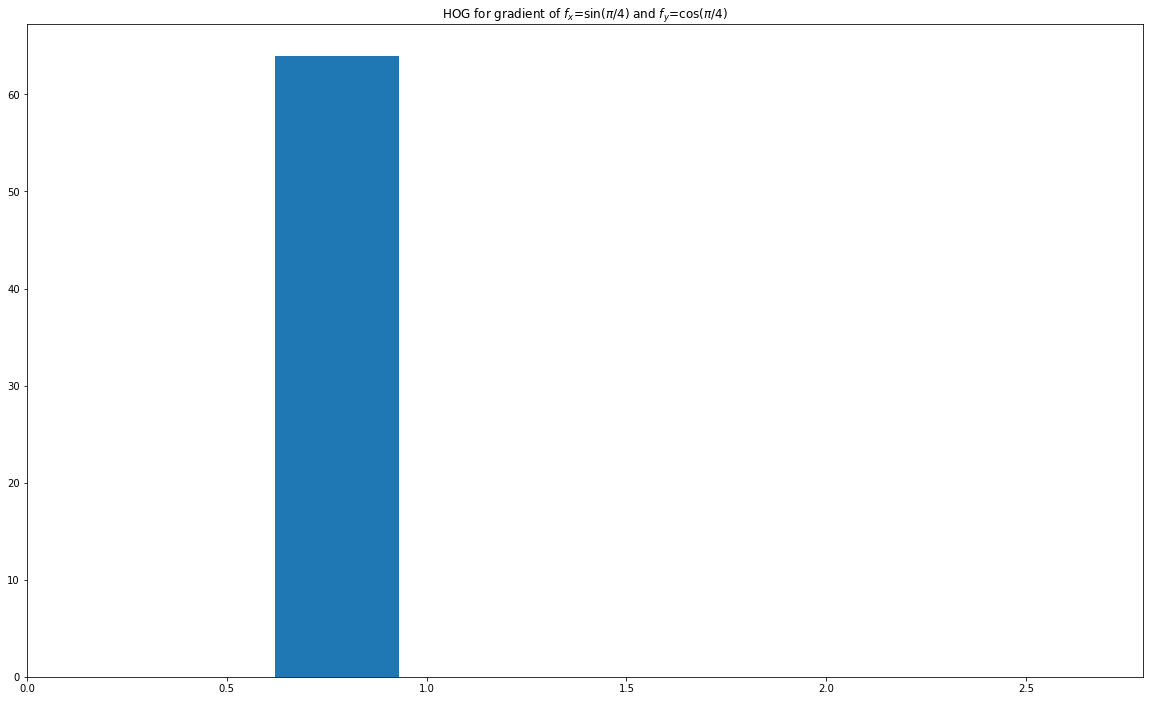

In [39]:
def cart2polar(fx, fy):
    
    mag = np.sqrt(fx * fx + fy * fy)
    angle = np.arctan2(fy, fx)
    
    return mag, angle
    
def HOG8x8_cart(fx, fy):
    
    mags, angles =  cart2polar(fx, fy)
    mags = mags.reshape(64)
    angles = angles.reshape(64)
    # keep angles between 0 and pi because atan2 has range (-pi, pi)
    angles[angles < 0] += np.pi
    
    return np.histogram(angles, bins=np.linspace(0, np.pi * (8/9.), 10), weights=mags)

# Test of the function, with pi/4 as argument the angle of the gradient should be 45 degrees (.78 rad)
# with a size of 1 (cos and sin define unit circle) which it is shown to be below
gx = np.ones((8,8))*np.sin(np.pi/4)
gy = np.ones((8,8))*np.cos(np.pi/4)

mag, angle = cart2polar(gx, gy)
print("Magnitude image")
print(mag)
print("Angle image")
print(angle)

# Get histogram and construct image to plot
hist, bin_edges = HOG8x8_cart(gx, gy)
binWidth = (bin_edges[0] + bin_edges[1])
plt.bar(bin_edges[:-1] + binWidth / 2, hist, width=binWidth)
plt.xlim(min(bin_edges), max(bin_edges))
plt.title("HOG for gradient of $f_x$=sin($\pi$/4) and $f_y$=cos($\pi$/4)")
plt.show()  

Finally, to get the final feature vector a normalisation is applied over 4 blocks of HOGs. This is done to smooth out lighting variations and other noise in our image. The next code section defines a function that does this for 4 input HOGs by concatenating them and the simply dividing by the norm of the concatenated vecor. A test is also done by putting 4 of the same 6-element vector into the function and checking the shape and norm of the input and output vectors.

In [35]:
def HOGblock(h1, h2, h3, h4):
    
    # Combine vectors into one single vector
    blockVector = np.hstack((h1, h2, h3, h4))
    # Normalise and return
    return (blockVector / norm(blockVector))

t = np.array([1, 2, 3, 4, 5, 6])
print("Shape of input vector: %s, norm: %s" % (t.shape, norm(t)))
block = HOGblock(t, t, t, t)
print("Shape of output vector: %s, norm: %s" % (block.shape, norm(block)))

Shape of input vector: (6,), norm: 9.53939201417
Shape of output vector: (24,), norm: 1.0


To calculate the HOG descriptor we first need to find the gradient direction at each point in the image. This is done by applying a convolution to the image with the x-gradient operator and also applying it with the y-gradient operator. In the implementation this means using the sobel operator on the image for horizontal and vertical directions. These operators are applied on both images to eliminate border effects in the final subimage, also the HOG8x8 function has been redefined to take input as polar coordinate gradients as opposed to cartesian. This is becase of efficiency and, again, elimination of border efects. Next, the subimage is picked out, converted to grayscale and resized to 64x128. This has to be done for both the magnitude and the angle image. Both images are then divided into 8x8 blocks and used to calculate the HOGs for these blocks. Finally the normalisation step is done to obtain the final descriptor, which is returned.

Also, an optional visualisation of the HOGs is contained in the function. However, this only plots the indivdual HOGs before normalisation and as such is not accurate in showing the real descriptor

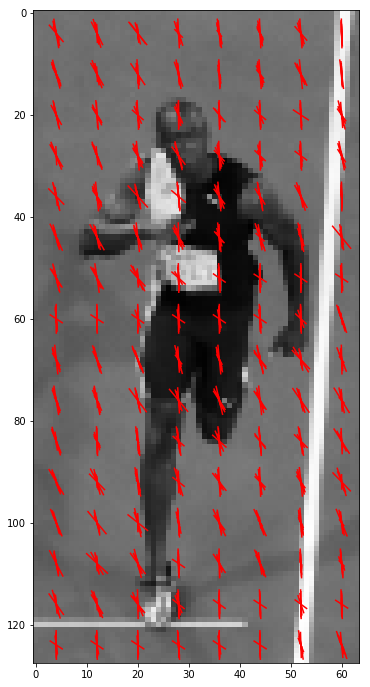

Shape of final descriptor of the image:
(105, 36)


In [53]:
# Plots a rose of directions at the given position 'pos' of the HOG.
def rose(HOG, pos, ax):
    
    angles = np.linspace(0, np.pi, 10)
    
    for angle, length in zip(HOG, angles):
        ax.plot([pos[0] - length * np.sin(angle), pos[0] + length * np.sin(angle)],
                [pos[1] - length * np.cos(angle), pos[1] + length * np.cos(angle)], color="red")

# Redefined function to take arguments as polar coordinates       
def HOG8x8_polar(fm, fa):
    
    shapeX, shapeY = fa.shape
    mags = fm.reshape(shapeX * shapeY)
    angles = fa.reshape(shapeX * shapeY)
    # keep angles between 0 and pi because atan2 has range (-pi, pi)
    angles[angles < 0] += np.pi
    
    return np.histogram(angles, bins=np.linspace(0, np.pi * (8/9.), 10), weights=mags)

def HOGimage(f, plot=False):
    
    # Convert image to grayscale for use in sobel filter
    f = color.rgb2gray(f)
    
    # Calculate gradients of image
    fx = sobel_h(f)
    fy = sobel_v(f)
    
    # Convert entire image to polar coordinates
    fmag, fangle = cart2polar(fx, fy)
    
    # Pick out subimage and resize
    bolt_fmag = resize(subImage(fmag, 100, 200, 205, 95), (128, 64))
    bolt_fangle = resize(subImage(fangle, 100, 200, 205, 95), (128, 64))
    
    # Set up iterator
    xs = [n for _ in range(16) for n in range(0, 57, 8)]
    ys = [n for n in range(0, 121, 8) for _ in range(8)]
    
    # Divide gradient image into blocks
    blocks_fmag = [bolt_fmag[x:x+8:,y:y+8:] for y, x in zip(xs, ys)]
    blocks_fangle = [bolt_fangle[x:x+8:,y:y+8:] for y, x in zip(xs, ys)]

    # Calculate HOG for each 8x8 cell
    HOGs = [HOG8x8_polar(xs, ys)[0] for xs, ys in zip(blocks_fmag, blocks_fangle)]
      
    # Normalise HOGs over 16x16 blocks
    HOGblocks = [HOGblock(HOGs[x + y]    , HOGs[x + y + 1],
                          HOGs[x + y + 8], HOGs[x + y + 9]) for x in range(7) for y in range(15)]
    
    if plot:     
        # Calculate normalised individual HOGs, only used for visualisation as plot
        HOGsNorm = [HOG / norm(HOG) for HOG in HOGs]
        # Make iterator for positions
        positions = [(x, y) for x in np.linspace(4, 60, 8) for y in np.linspace(4, 124, 16)]

        fig, ax = plt.subplots(1, 1)
        ax.imshow(resize(subImage(f, 100, 200, 205, 95), (128, 64)), cmap='gray')

        #Plot rose of directions for each HOG (NOT using the full HOG desciptor)
        for HOG, pos in zip(HOGsNorm, positions):
            rose(HOG, pos, ax)

        plt.show()
        
    return np.array(HOGblocks)

HOG_descriptor = HOGimage(imread('bolt2.png'), plot=True)

print("Shape of final descriptor of the image:")
print(HOG_descriptor.shape)

The final descriptor has the correct size (105 x 36 = 3780), and the visualisation shows on some points a very clear trend in the direcion of the gradient. Strangely enough however, almost all HOGs have an orientation which is in the same diagonal direction, almost none go from lower left to lower right.